In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [4]:
df.duplicated().sum()

418

In [5]:
df = df.drop_duplicates()

In [6]:
df.shape[0]

49582

In [7]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import string

In [8]:
def normalize_text(text):
    text = text.lower()
    text = re.sub('<.*?>','', text)
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub('\\W',' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

In [9]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    sentence = ''
    for word in words:
        if word not in stop_words:
            sentence = sentence + word + ' '
    return sentence

In [10]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [11]:
def stemmer(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence
    

In [12]:
def clean_text(text):
    text = text.lower()
    
    text = normalize_text(text)
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = text.replace("'", " ' ")
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemmer(text)
    return text

In [13]:
df['review'] = df['review'].apply(clean_text)

In [14]:
df.head()

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


In [15]:
X = df['review'].values
y = df['sentiment'].values

In [16]:
X

array(['one review mention watch 1 oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side

In [17]:
y

array(['positive', 'positive', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [18]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)

In [20]:
tf = TfidfVectorizer()
lr = LogisticRegression()
log_reg_model = Pipeline([('vectorizer', tf), ('classifier', lr)])
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [50, 100, 200, 300]
}
grid_search = GridSearchCV(estimator=log_reg_model,
                           param_grid=param_grid, cv=5,n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters:  {'classifier__C': 1.0, 'classifier__max_iter': 50, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best Score:  0.8906088491113072


In [21]:
test_score = best_model.score(X_test, y_test)
print("Test Score: ", test_score)

Test Score:  0.892104467076737


In [27]:
tf = TfidfVectorizer()
lr = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=50)
model = Pipeline([('vectorizer', tf), ('classifier', lr)])
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(max_iter=50, solver='saga'))])

In [28]:
y_pred = model.predict(X_test)

<Axes: >

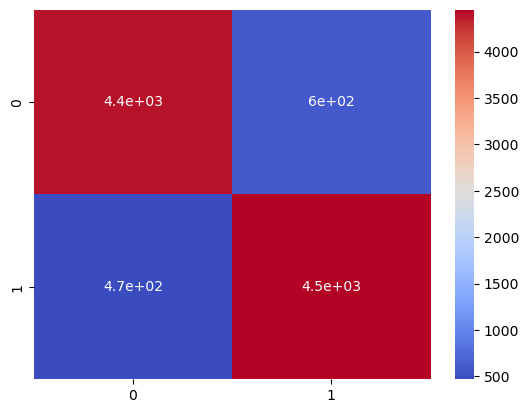

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='coolwarm')

In [30]:
lr_accuracy = accuracy_score(y_test, y_pred)
print(lr_accuracy)

0.8920036301300797


In [26]:
dt = DecisionTreeClassifier()
dt_model = Pipeline([('vectorizer', tf), ('classifier', dt)])
param_grid = {
    'classifier__criterion':['gini','entropy'],
    'classifier__splitter':['best', 'random'],
    'classifier__max_depth':[None,1, 5, 10, 20],
    'classifier__max_leaf_nodes':[None, 10, 20, 30],
    'classifier__ccp_alpha':[0.0,0.01,0.1,0.001]
}
grid_search = GridSearchCV(estimator= dt_model, param_grid=param_grid,
                           cv = 5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters:  {'classifier__ccp_alpha': 0.001, 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_leaf_nodes': None, 'classifier__splitter': 'best'}
Best Score:  0.7567628891970252


In [32]:
dt = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.001, max_depth=None, max_leaf_nodes=None, splitter='best')
dt_model = Pipeline([('vectorizer', tf), ('classifier', dt)])
dt_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy'))])

In [34]:
y_pred = dt_model.predict(X_test)

In [36]:
dt_accuracy = accuracy_score(y_test, y_pred)
print(dt_accuracy)

0.7544620348895835


In [37]:
rf = RandomForestClassifier()
rf_model = Pipeline([('vectorizer', tf), ('classifier', rf)])
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5,n_jobs=-1, verbose=2)
grid_search.fit(X_train,y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


C:\Users\shafy\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
307 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shafy\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shafy\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\shafy\AppData\Roaming\Python\Python312\si

Best Parameters:  {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Score:  0.8603302659775622


In [40]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=None, bootstrap=False)
rf_model = Pipeline([('vectorizer', tf), ('classifier', rf)])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, min_samples_leaf=2,
                                        n_estimators=200))])

In [41]:
y_pred = rf_model.predict(X_test)

array(['negative', 'negative', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

In [42]:
rf_accuracy = accuracy_score(y_test, y_pred)
rf_accuracy

0.8586266007865282

In [44]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']
accuracy = [lr_accuracy, dt_accuracy, rf_accuracy]
results = pd.DataFrame({'Models':models, 'Accuracy':accuracy})


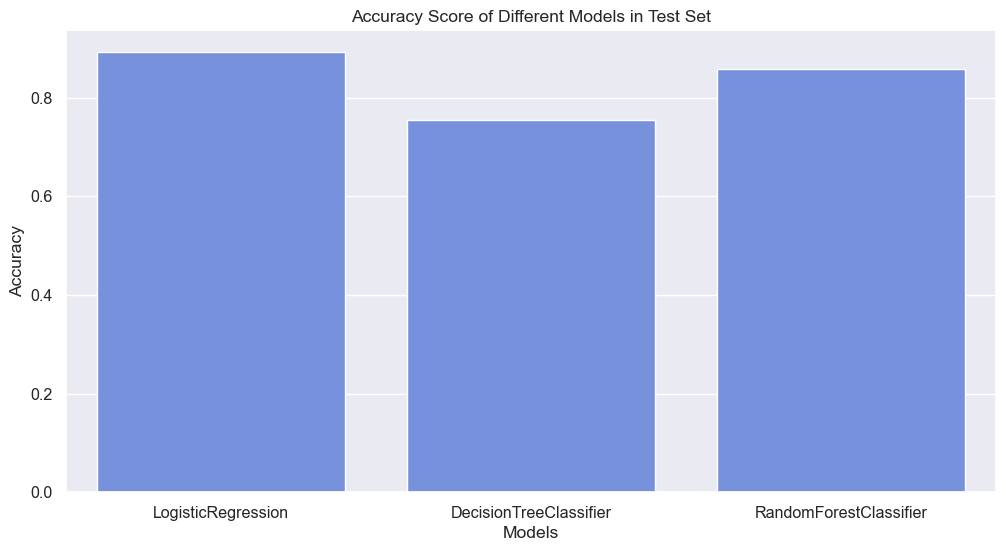

In [ ]:
plt.figure(figsize=(12,6))
plt.grid(True)
sns.set_theme(palette='coolwarm', style='darkgrid', font_scale=1.05)
plt.title("Accuracy Score of Different Models in Test Set")
plt.xlabel("Models")
plt.ylabel("Accuracy")
sns.barplot(x=results.Models, y=results.Accuracy)
plt.show()

In [89]:
def test():
    text = input("Review: ")
    a = text
    print("The Review:", a)
    text = normalize_text(text)
    pred = model.predict([text])
    print("Result:", pred[0]) 

In [90]:
review = 'This movie is absolutely terrible. The directing, acting, script and production are all bad. There is actually NOTHING redeemable about it.'
test()

The Review: This movie is absolutely terrible. The directing, acting, script and production are all bad. There is actually NOTHING redeemable about it.
Result: negative


In [91]:
review = 'Excellent spy thriller ... Loved this movie. Joshua Caldwell actually takes the time for the audience to get to know and understand the characters so you care ...'
test()

The Review: Excellent spy thriller ... Loved this movie. Joshua Caldwell actually takes the time for the audience to get to know and understand the characters so you care ...
Result: positive


In [93]:
review = "People seem of two minds about this film: it either moves them to tears or to nausea. But in reality, it is a well-made film with some strong performances but not more than that. The core of this movie that is as simple minded as the title character; the facile speciousness of the movie's reactionary attacks on matters I agreed with made me realize just how shallow the movie's entire argument is.  But beyond that, the movie is very well made; Hanks's performance could have been annoying in other hands but works well here. Sinise was excellent as well. Robin Wright's performance was adequate - I try not to blame her for the movie's implied argument that the social movements of the 60's and 70's were a working out of childhood neuroses - but never really stuck to me. The technical aspects of the film are outstanding, and the movie has a lot of laughs and tears despite its empty headed core.  If it helps anyone, this is my wife's favorite movie. But then, she fell asleep during Casablanca, so...."
test()

The Review: People seem of two minds about this film: it either moves them to tears or to nausea. But in reality, it is a well-made film with some strong performances but not more than that. The core of this movie that is as simple minded as the title character; the facile speciousness of the movie's reactionary attacks on matters I agreed with made me realize just how shallow the movie's entire argument is.  But beyond that, the movie is very well made; Hanks's performance could have been annoying in other hands but works well here. Sinise was excellent as well. Robin Wright's performance was adequate - I try not to blame her for the movie's implied argument that the social movements of the 60's and 70's were a working out of childhood neuroses - but never really stuck to me. The technical aspects of the film are outstanding, and the movie has a lot of laughs and tears despite its empty headed core.  If it helps anyone, this is my wife's favorite movie. But then, she fell asleep durin